In [31]:
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://huggingface.co/blog/fine-tune-vit
# https://huggingface.co/google/vit-base-patch16-224-in21k
# ViT model: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py#L37

Size of data_coins 10 : Size of labels_coins 10
Size of data_others 10 : Size of labels_others 10


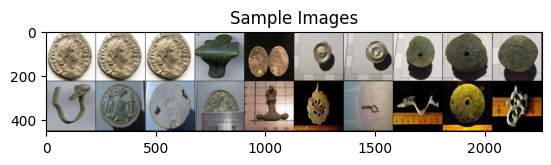

In [32]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from PIL import Image

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images
'''
path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_coin_256x256/"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_others_256x256/"
'''

path_to_coins = "/mnt/c/Users/bucha/Pictures/coins_224x224"
path_to_others = "/mnt/c/Users/bucha/Pictures/other_224x224"


def load_data_from_directory_with_limit(directory_path, label, limit=10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label=1, limit=10)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label=0, limit=10)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images = 30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow = 10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images=num_images_to_display_per_category * 2)

In [75]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors=(coin_dataT, coin_labelsT), transform=imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors=(other_dataT, other_labelsT), transform=imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size - GPU may be overloaded with memory allocations if too high
BATCH_SIZE = 2
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size=BATCH_SIZE, shuffle=False) # For test -> below cell
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 14 : Each batch size 7
Total number of elements in val_loader: 4 : Each batch size 2
Total number of elements in test_loader: 4 : Each batch size 2


In [76]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, AdamW
import torch

model_name_or_path = 'google/vit-base-patch16-224-in21k'
vit_model = ViTForImageClassification.from_pretrained(model_name_or_path)
vit_model.size = {"height": 256, "width": 256}

# Model configs
print(vit_model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
threshold = 0.5

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_model.to(device)

def get_prediction(predictions):
    # Finding the largest value in the tensor
    largest_value = torch.max(predictions)
    print(predictions.size(), "HVAD VI FÅR I METODEN")
    print(largest_value, "STØRSTE INDEN SIGMOID")

    # Applying sigmoid to the largest value
    sigmoid_largest = torch.sigmoid(largest_value)
    print(sigmoid_largest, "LARGEST")

    if sigmoid_largest < threshold:
        prediction = torch.tensor(0.0)
    else:
        prediction = torch.tensor(1.0)

    print(prediction, "INDEN RETURN")
    return (prediction)

def compute_metrics(predictions, labels):
    """
    Compute accuracy for binary classification.

    Args:
        predictions (torch.Tensor): Model predictions.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: Accuracy value.
    """
    # Apply sigmoid to convert logits to probabilities
    probabilities = torch.sigmoid(predictions)

    # Convert probabilities to binary predictions (0 or 1)
    binary_predictions = (probabilities > 0.5).float()

    # Compare binary predictions with ground truth labels
    correct_predictions = (binary_predictions == labels).float()

    # Calculate accuracy
    accuracy = correct_predictions.mean().item()

    return accuracy
    

for epoch in range(num_epochs):
    vit_model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        prediction = get_prediction(outputs.logits)
        print(f'prediction: {prediction.size()}') 
        print(f'prediction: {prediction}')
        loss = criterion(prediction, labels.float())
        loss.backward()
        optimizer.step()

    vit_model.eval()

    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
     
            outputs = vit_model(inputs)
            prediction = get_prediction(outputs.logits) 
            val_loss = criterion(prediction, labels.float())
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Validation Loss: {average_val_loss}')

torch.Size([2, 2]) HVAD VI FÅR I METODEN
tensor(0.2343, grad_fn=<MaxBackward1>) STØRSTE INDEN SIGMOID
tensor(0.5583, grad_fn=<SigmoidBackward0>) LARGEST
tensor(1.) INDEN RETURN
prediction: torch.Size([])
prediction: 1.0


ValueError: Target size (torch.Size([2, 1])) must be the same as input size (torch.Size([]))